# COVID-19 Impact on Hospital Capacity

This notebook presents my portion of our team's analysis for the SIADS 593 Milestone I project, focusing on the impact of COVID-19 on hospital capacity. Our goal is to explore how the pandemic has affected hospital resources, specifically looking at bed availability across different states, with a closer look at Michigan. I utilized two public datasets to conduct our analysis: hospital capacity data and COVID-19 case data.

**Datasets**:
- Hospital Capacity by Facility
- Weekly U.S. COVID-19 Cases and Deaths by County

**Team Member Responsible**: Numan Suri

**Mentor**: Dr. Chris Teplovs


In [391]:
# Importing necessary libraries for data manipulation and visulation and defining and loading files to convert into DataFrames.
import pandas as pd
import matplotlib.pyplot as plt

file_path_h = "/Users/numan/Desktop/Milestone 1/milestone-one/src/data/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_Facility_20240114.csv"
file_path_c = "/Users/numan/Desktop/Milestone 1/milestone-one/src/data/Weekly_United_States_COVID-19_Cases_and_Deaths_by_County_-_ARCHIVED_20240113.csv"

hospital_df = pd.read_csv(file_path_h)
covid_df = pd.read_csv(file_path_c)

/var/folders/9m/3n1wq0l97pgc3qn83dw9hqs80000gn/T/ipykernel_28251/1484683388.py:8: DtypeWarning: Columns (0,3,108) have mixed types. Specify dtype option on import or set low_memory=False.
  hospital_df = pd.read_csv(file_path_h)


In [392]:
# Starting off with data cleaning, need to remove any and all negative values that are not plausible in this context.
columns_to_check = [ 
    'total_beds_7_day_avg',
    'total_beds_7_day_sum', 
    'inpatient_beds_used_covid_7_day_avg',
    'inpatient_beds_used_covid_7_day_sum',
    'total_icu_beds_7_day_avg', 
    'staffed_adult_icu_bed_occupancy_7_day_avg',  
]

# Cleaning specified columns in hospital_df to have no negative values
for column in columns_to_check:
    if column in hospital_df.columns:
        hospital_df[column] = hospital_df[column].clip(lower=0)


In [393]:
# Next, I am going to select the columns I need to focus on for the analysis and to simplify the dataset.
columns_of_interest = [
    'collection_week', 
    'total_beds_7_day_sum', 
    'inpatient_beds_used_covid_7_day_sum',
    'state', 
]

hospital_df = hospital_df[columns_of_interest]

Once the cleaning and selecting columns is complete, we can now move on to data type conversions for proper merging of both datasets.

In [394]:
# Convert 'collection_week' and 'date' to datetime
hospital_df['collection_week'] = pd.to_datetime(hospital_df['collection_week'], errors='coerce').copy()
covid_df['date'] = pd.to_datetime(covid_df['date'], errors='coerce').copy()

In [395]:
# Extract the week and year from the date
hospital_df['year'] = hospital_df['collection_week'].dt.isocalendar().year
hospital_df['week'] = hospital_df['collection_week'].dt.isocalendar().week

covid_df['year'] = covid_df['date'].dt.isocalendar().year
covid_df['week'] = covid_df['date'].dt.isocalendar().week


In [396]:
# Create a temporary covid weekly DataFrame that groups the raw covid data by the year and week and aggregates new cases
# by mean and new deaths by sum.
covid_weekly = covid_df.groupby(['year', 'week']).agg({
    'New cases': 'mean',
    'New deaths': 'sum',
}).reset_index()

In [397]:
# The time has finally come to merge the shrunken hospital DataFrame and the temporary covid weekly DataFrame together
# on the year and week, doing an inner merge.
merged_df = pd.merge(
    hospital_df, 
    covid_weekly, 
    on=['year', 'week'], 
    how='inner'
)

In [398]:
# Time to see what we have done so far.
merged_df.head()

,collection_week,total_beds_7_day_sum,inpatient_beds_used_covid_7_day_sum,state,year,week,New cases,New deaths
0,2020-04-26,NaN,NaN,AL,2020,17,60.861858,15567
1,2020-04-26,NaN,22.0,CA,2020,17,60.861858,15567
2,2020-04-26,NaN,107.0,FL,2020,17,60.861858,15567
3,2020-04-26,840.0,6.0,GA,2020,17,60.861858,15567
4,2020-04-26,1197.0,4.0,HI,2020,17,60.861858,15567


In [399]:
# Final little clean up here to round these specific hospital columns to 2 decimal places.
columns_to_round = [
    'inpatient_beds_used_covid_7_day_sum',
    'total_beds_7_day_sum'
]

merged_df[columns_to_round] = merged_df[columns_to_round].round(2)

Now we can focus on starting to prep our merged DataFrame to create the visualization (graph showing covid cases, deaths, and covid bed usage over time).

In [400]:
# We start by filtereing and sorting for Michigan data by year and week.
mi_data = merged_df[merged_df['state'] == 'MI'].sort_values(['year', 'week'])

# Generating a unique identifier for each week by combining year and week number
mi_data['year_week'] = mi_data['year'].astype(str) + '-' + mi_data['week'].astype(str)

# Calculate the percentage of inpatient beds used for COVID-19 out of total beds
mi_data['covid_bed_usage_pct'] = (mi_data['inpatient_beds_used_covid_7_day_sum'] / mi_data['total_beds_7_day_sum']) * 100

# Calculate the rolling average
mi_data['rolling_avg'] = mi_data['covid_bed_usage_pct'].rolling(window=4).mean()

# Group the data by 'year_week' and calculate the mean of the rolling average
average_bed_usage = mi_data.groupby('year_week')['rolling_avg'].mean().reset_index()


Now we are ready to start the plotting portion of this analysis.

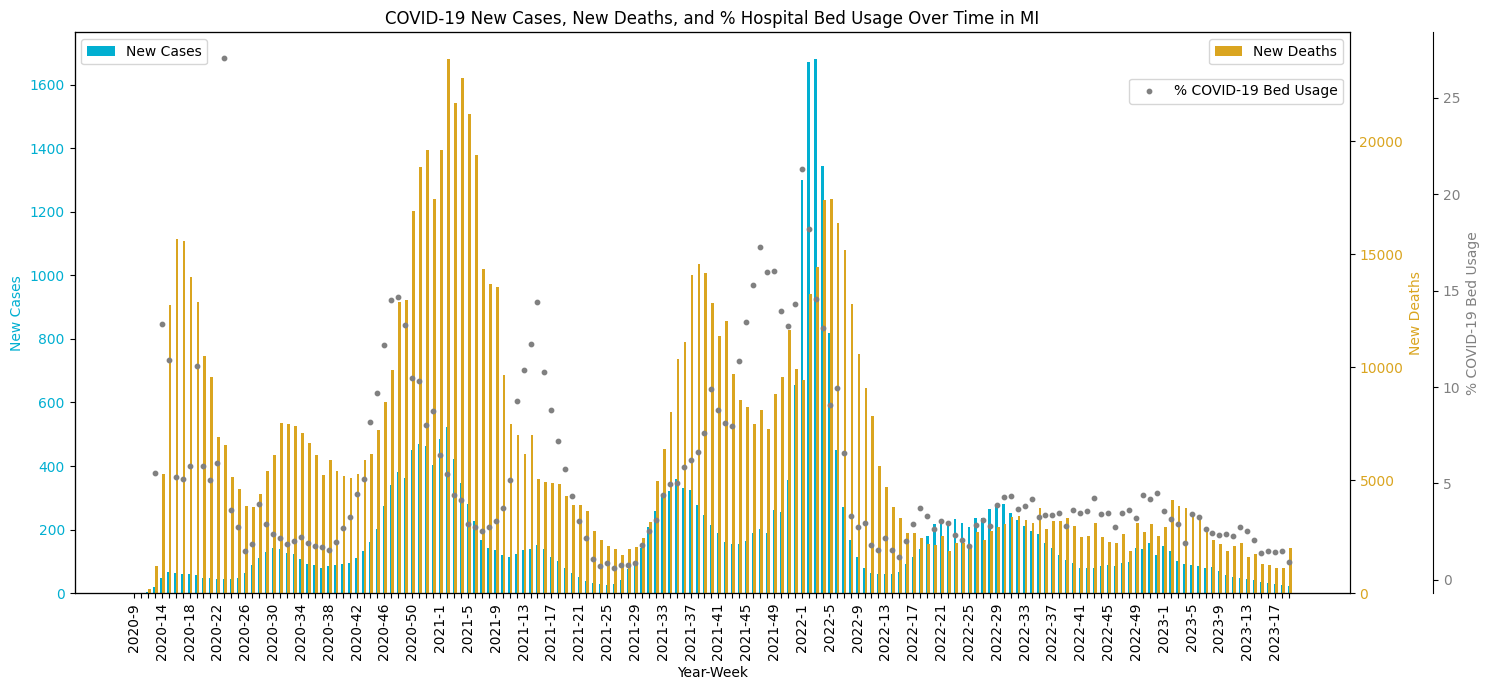

In [401]:
# Create a new figure and subplot
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot 'New cases' on the left y-axis
color = '#01afd1'
ax1.set_xlabel('Year-Week')
ax1.set_ylabel('New Cases', color=color)
ax1.bar(mi_data['year_week'], mi_data['New cases'], color=color, label='New Cases', width=0.4, align='center')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for 'New deaths'
ax2 = ax1.twinx()
color = '#DAA520'
ax2.set_ylabel('New Deaths', color=color)
ax2.bar(mi_data['year_week'], mi_data['New deaths'], color=color, label='New Deaths', width=0.4, align='edge')
ax2.tick_params(axis='y', labelcolor=color)

# Create a third y-axis for hospital bed usage
ax3 = ax1.twinx()
# Offset the right spine of ax3. The ticks and label have already been placed on the right by twinx above.
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis to the right
color = '#808080'
ax3.set_ylabel('% COVID-19 Bed Usage', color=color)
# Use 'average_bed_usage' for plotting the percentage of COVID-19 bed usage
ax3.scatter(average_bed_usage['year_week'], average_bed_usage['rolling_avg'], color=color, label='% COVID-19 Bed Usage', s=10)
ax3.tick_params(axis='y', labelcolor=color)

# Set the title of the plot
plt.title('COVID-19 New Cases, New Deaths, and % Hospital Bed Usage Over Time in MI')

# Rotate the date labels for better readability
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)

# Adjust the ticks to show every Nth label to avoid clutter
for index, label in enumerate(ax1.xaxis.get_ticklabels()):
    if index % 4 != 0:
        label.set_visible(False)

# Show the legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right', bbox_to_anchor=(1, 0.93))

# Show the plot
plt.tight_layout()
plt.show()